In [1]:
import numpy as np

import pydot
from IPython.display import display, SVG

from matplotlib import pyplot as plt

from RobotDiagram import RobotDiagram
from AbbMotionPlanner import AbbMotionPlanner
from GripperMotionController import GripperMotionController

from pydrake.all import (
    DiagramBuilder,
    StartMeshcat,
    Simulator,
    Diagram,
    VectorLogSink,
    RigidTransform,
    RotationMatrix,
    ConstantVectorSource,
    VectorLogSink,
    Context,
    AbstractValue,
    Rgba,
    Box,
    MeshcatPointCloudVisualizer
)

In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [3]:
def get_diagram(X_WG:RigidTransform) -> tuple[Diagram, Context]:
    builder = DiagramBuilder()
    system = builder.AddNamedSystem("plant_subsystem", RobotDiagram(0.001, meshcat=meshcat, models_to_add=["world/world.sdf"]))

    svh_desired_state = system.GetInputPort("svh_desired_state")
    irb_desired_state = system.GetInputPort("irb1200_desired_state")

    abb_motion_planner = builder.AddSystem(AbbMotionPlanner(5))
    builder.Connect(abb_motion_planner.get_output_port(), irb_desired_state)

    desired_sink:VectorLogSink = builder.AddNamedSystem("desired_sink", VectorLogSink(abb_motion_planner.get_output_port().size()))
    builder.Connect(abb_motion_planner.get_output_port(), desired_sink.get_input_port())

    svh_source = builder.AddSystem(ConstantVectorSource(np.zeros(svh_desired_state.size())))

    builder.Connect(svh_source.get_output_port(), svh_desired_state)

    svh_state = system.GetOutputPort("svh_state")
    irb_state = system.GetOutputPort("irb1200_state")

    builder.Connect(irb_state, abb_motion_planner.GetInputPort("irb1200_estimated_state"))
    svh_sink:VectorLogSink = builder.AddNamedSystem("svh_sink", VectorLogSink(svh_state.size()))
    irb_sink:VectorLogSink = builder.AddNamedSystem("irb_sink", VectorLogSink(irb_state.size()))

    builder.Connect(svh_state, svh_sink.get_input_port())
    builder.Connect(irb_state, irb_sink.get_input_port())
    builder.ExportOutput(system.GetOutputPort("camera0_color_image"), "camera0_color_image")
    builder.ExportOutput(system.GetOutputPort("camera0_depth_image"), "camera0_depth_image")

    pc_vis = builder.AddSystem(MeshcatPointCloudVisualizer(meshcat, "/drake"))
    builder.Connect(system.GetOutputPort("point_cloud"), pc_vis.cloud_input_port())

    diagram:Diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    abb_motion_planner.GetInputPort("target_ee_location").FixValue(abb_motion_planner.GetMyContextFromRoot(context), AbstractValue.Make(X_WG))
    return diagram, context


0
standard_case_x
standard_case_z
optimization succeeded


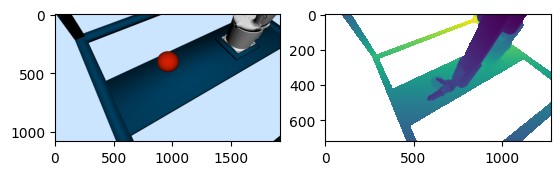

In [5]:

def show_mock_triad(name:str, pose:RigidTransform):
    # Create a triad like object that shows the goal orientation
    meshcat.SetObject(name+"_x", Box(0.02, 0.02, 0.06), rgba=Rgba(0.9, 0.1, 0.1, 1))
    meshcat.SetTransform(name+"_x", pose @ RigidTransform(RotationMatrix().MakeYRotation(-np.pi/2), [0.03, 0, 0]))

    meshcat.SetObject(name+"_y", Box(0.02, 0.02, 0.06), rgba=Rgba(0.1, 0.9, 0.1, 1))
    meshcat.SetTransform(name+"_y", pose @ RigidTransform(RotationMatrix().MakeXRotation(np.pi/2), [0, 0.03, 0]))

    meshcat.SetObject(name+"_z", Box(0.02, 0.02, 0.06), rgba=Rgba(0.1, 0.1, 0.9, 1))
    meshcat.SetTransform(name+"_z", pose @ RigidTransform(RotationMatrix(), [0, 0, 0.03]))

meshcat.Delete()
meshcat.DeleteRecording()
meshcat.DeleteAddedControls()

X_WG = RigidTransform(RotationMatrix().MakeXRotation(np.pi) @ RotationMatrix().MakeYRotation(np.pi/2), [0.7, 0.2, 0.3])

# Simulation
diagram, context = get_diagram(X_WG)
sim = Simulator(diagram, context)
sim.Initialize()
color_image = diagram.GetOutputPort("camera0_color_image").Eval(context)
depth_image = diagram.GetOutputPort("camera0_depth_image").Eval(context)

meshcat.StartRecording()
sim.AdvanceTo(10.0)
meshcat.PublishRecording()

X_WC = diagram.GetSubsystemByName("plant_subsystem").camera_pos_
show_mock_triad("goal", X_WC)

fig, axs = plt.subplots(1,2)
axs[0].imshow(color_image.data)
axs[1].imshow(depth_image.data)